Run the code by either:
1. selecting `Run all` from the `Cell` dropdown menu above
2. run cell-by-cell, by pressing `Shift + Enter` on your keyboard
  * note; `Alt + Enter` runs a cell and inserts an empty cell below

In [1]:
from typing import Union, List, Any, Optional, Dict

import os
import re
import time
import json
import glob
import pickle
import random
import urllib
import requests
import subprocess
import concurrent.futures

import numpy as np
import pandas as pd
import seaborn as sns

from bs4 import BeautifulSoup
from tqdm import tqdm
from pathlib import Path
from textblob import TextBlob
from threading import current_thread
from matplotlib import pyplot as plt
from collections import Counter
from transformers import BertTokenizer, BertModel
from gap_statistic import OptimalK
from sklearn.cluster import KMeans #, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

from utils import cluster_utils
from utils import cleaning_utils
from utils import IDF_computation
from utils import embedding_utils as embedding
from utils.customdocument import CustomDocument

<div class="alert alert-block alert-info"> 
We will run our term extraction on the Merged Approved Documents, the .pdf file can be found in the `data/` directory. For filtering of out-of-domain terms we will also process a set of EU regulations for medical device design, the .html files for these can be found in the same directory.
</div>

1. Preprocessing will consist only of removing headers/footers from PDF files. 

2. Candidate terms are identified using SPaR.txt (Kruiper et al., 2021), sentence splitting is done with the PunkSentTokenizer (Strunk, 2006).

3. Filtering of term candidates consists of:
  * a set of regular expressions found in utils.py
  * clustering of terms found in (1) the Approved Documents, and (2) a set of EU regulations for medical device design; any clusters containing terms from (2) will be designated as terms that are irrelevant to the AEC domain.
  
 


### 1 Preprocessing: get text from PDF and HTML

<div class="alert alert-block alert-info">
Here, we grab the text from our foreground and background corpora.
</div>


In [2]:
input_path = Path("data/term_extraction_input/")
output_dir = Path("data/converted_documents/")
output_dir.mkdir(parents=True, exist_ok=True) # create the converted_documents directory if needed

# NOTE: in our case the foreground corpus is the merged_approved_pdf_file, 
#       and the background corpus is a set of html files
merged_approved_pdf_file = [x for x in input_path.glob("*.pdf")][0]
eu_html_files = [x for x in input_path.glob("*.html")]

print(f"Approved Documents: {merged_approved_pdf_file}")
print(f"Reference corpus: {[str(x) for x in eu_html_files]}")

Approved Documents: data/term_extraction_input/The Merged Approved Documents.pdf
Reference corpus: ['data/term_extraction_input/EUR-Lex - 31993L0042 - EN.html', 'data/term_extraction_input/CELEX 32017R0746 EN TXT.html', 'data/term_extraction_input/CELEX 32017R0745 EN TXT.html', 'data/term_extraction_input/EUR-Lex - 31998L0079 - EN.html', 'data/term_extraction_input/EUR-Lex - 31990L0385 - EN.html']


In [3]:
merged_approved_pdf_file.exists()

True

<div class="alert alert-block alert-info">
First we grab the text from the Merged Approved Documents pdf file. Our implementation on based on the pdf conversion pipeline in Haystack.
</div>

In [4]:
def read_pdf(file_path: Path, layout: bool = True, encoding: Optional[str] = "Latin1") -> List[str]:
        """
        Extract pages from the pdf file at file_path; based on Haystack.

        :param file_path: path of the pdf file
        :param layout: whether to retain the original physical layout for a page. If disabled, PDF pages are read in
                       the content stream order.
        """
        if layout:
            command = ["pdftotext", "-enc", encoding, "-layout", str(file_path), "-"]
        else:
            command = ["pdftotext", "-enc", encoding, str(file_path), "-"]
        output = subprocess.run(command, stdout=subprocess.PIPE, shell=False)  # type: ignore
        document = output.stdout.decode(errors="ignore")
        pages = document.split("\f")
        pages = pages[:-1]  # the last page in the split is always empty.
        return pages

def convert_pdf_to_mydoc(source_file_path: Path, 
                         output_file_path: Path, 
                         meta: Optional[Dict[str, str]] = None,
                         remove_header_and_footer: Optional[bool] = True,
                         clean_whitespace: Optional[bool] = True,
                         clean_empty_lines: Optional[bool] = True,
                         encoding: Optional[str] = "Latin1") -> CustomDocument:
        """
        Extract pages from the pdf file at file_path; based on Haystack.

        :param output_file_path:    Path to the .json file to store the converted file.
        :param source_file_path:    Path to the .pdf file you want to convert
        :param meta: Optional dictionary with metadata that shall be attached to all resulting documents.
                     Can be any custom keys and values.
        :param encoding: Encoding that will be passed as -enc parameter to pdftotext. "Latin 1" is the default encoding
                         of pdftotext. While this works well on many PDFs, it might be needed to switch to "UTF-8" or
                         others if your doc contains special characters (e.g. German Umlauts, Cyrillic characters ...).
                         Note: With "UTF-8" we experienced cases, where a simple "fi" gets wrongly parsed as
                         "xef\xac\x81c" (see test cases). That's why we keep "Latin 1" as default here.
                         (See list of available encodings by running `pdftotext -listenc` in the terminal)
        """
        pages = read_pdf(source_file_path, layout=True, encoding=encoding)

        if not pages:
            # empty input file
            return None
        
        pages = ["\n".join(p.splitlines()) for p in pages]

        # splitting text happens during preprocessing, so no split_size passed here;
        # split_size will be set to -1 during conversion.
        document = CustomDocument(output_file_path, source_file_path, split_size=-1)
        
        print("Converted PDF file to pages of text, combining to a single CustomDocument to keep track of page nrs.")
        for page_idx, page in tqdm(enumerate(pages)):
            
            # some simple cleaning -- roughly based on haystack.
            lines = page.splitlines()
            if remove_header_and_footer:
                # simplest way for removing header and footer 
                lines = lines[1:-2]

            if clean_whitespace:
                cleaned_lines = []
                for line in lines:
                    line = line.strip()
                    cleaned_lines.append(line)
                text = " ".join(cleaned_lines)

            if clean_empty_lines:
                text = re.sub(r"\n\n+", "\n\n", text)
                text = re.sub(r"[\s]+", " ", text)
            
            # no splitting here yet, so simply using page_nr as a place holder and split_id is left blank
            page_nr = str(page_idx + 1)
            document.add_content(text=text, 
                                 page_nr=page_nr, 
                                 doc_title=source_file_path.name)   # we're using the pdf file name for simplicity

        return document

In [5]:
output_path = output_dir.joinpath("merged_approved.json")
merged_approved_document = convert_pdf_to_mydoc(merged_approved_pdf_file, output_path)

Converted PDF file to pages of text, combining to a single CustomDocument to keep track of page nrs.


1455it [00:00, 8701.59it/s]


In [6]:
print(f"Maximum character length for a single block of text: {max([len(c.text) for c in merged_approved_document.all_contents])}")

Maximum character length for a single block of text: 5349


<div class="alert alert-block alert-info">
Second, we grab the text from the EU regulation HTML files. Because the text in HTML files isn't split into pages, the blocks of text are much longer.
</div>

In [7]:
def grab_HTML_text_simple(file_path: Path):
    """
    All text in the EU htmls seems to be captured neatly in <p> tags, we don't care about structure currently.
    We do remove all unicode characters, see `utils.remove_unicode_chars()`.
    """ 
    with open(file_path, 'r') as f:
        text = f.read()
    soup = BeautifulSoup(text, 'html.parser')
    return [cleaning_utils.remove_unicode_chars(x.text) for x in soup.body.find_all('p')]

In [8]:
def convert_html_to_mydoc(source_file_path: Path, 
                          output_file_path: Path) -> CustomDocument:
    
    document = CustomDocument(output_file_path, source_file_path, split_size=-1)
    document_paragraphs = []
    list_of_paragraphs = grab_HTML_text_simple(source_file_path)
    for paragraph in list_of_paragraphs:
        if paragraph.strip() != '':
            document_paragraphs.append(paragraph)
    
    for paragraph_idx, paragraph in tqdm(enumerate(document_paragraphs)):
            # no splitting here yet, so simply using page_nr as a place holder and split_id is left blank
            paragraph_nr = str(paragraph_idx + 1)
            document.add_content(text=paragraph, 
                                 page_nr=paragraph_nr, 
                                 doc_title=source_file_path.name) # we're using the html file name for simplicity
    return document

In [9]:
eu_regulation_documents = []

for html_file in tqdm(eu_html_files):
    output_path = output_dir.joinpath(html_file.stem + ".json")
    eu_regulation_documents.append(convert_html_to_mydoc(html_file, output_path))


  0%|                                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]
826it [00:00, 249298.06it/s]

4344it [00:00, 361122.14it/s]
 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 2/5 [00:00<00:01,  2.49it/s]
4799it [00:00, 378319.05it/s]
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 3/5 [00:01<00:01,  1.94it/s]
623it [00:00, 316887.14it/s]
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 4/5 [00:01<00:00,  2.64it/s]
511it [00:00, 297637.74it/s]
100%|███████████████████████████

In [10]:
print(f"Maximum character length for a single paragraph: {max([len(c.text) for d in eu_regulation_documents for c in d.all_contents])}")

Maximum character length for a single paragraph: 143428


<div class="alert alert-block alert-info">
Third, if the output document doesn't exist (yet), we save the ConvertedDocument.
</div>

In [11]:
foreground_corpus = [merged_approved_document]
background_corpus = eu_regulation_documents

In [12]:
for d in foreground_corpus + background_corpus:
    if not os.path.exists(d.output_fp):
        d.write_document()

### 2 Term extraction: identify object spans with SPaR.txt

<div class="alert alert-block alert-info">
For each of the sentences in our corpora, we run SPaR.txt for object identification.
</div>


Note; on a mac, you may have to install the Xcode commandline developer tools. Open a terminal window and run `xcode-select --install` or download Xcode through the App store.



In [13]:
# download SPaR.txt if required
from pathlib import Path
spartxt_path = Path("SPaR.txt/")
if not spartxt_path.exists():
    !git clone https://github.com/rubenkruiper/SPaR.txt.git

Cloning into 'SPaR.txt'...
remote: Enumerating objects: 11890, done.
remote: Counting objects: 100% (2223/2223), done.
remote: Compressing objects: 100% (1170/1170), done.
remote: Total 11890 (delta 881), reused 2199 (delta 859), pack-reused 9667
Receiving objects: 100% (11890/11890), 4.85 MiB | 2.69 MiB/s, done.
Resolving deltas: 100% (1258/1258), done.
Updating files: 100% (14621/14621), done.


In [14]:
import imp
with open(spartxt_path.joinpath('spar_predictor.py'), 'rb') as fp:
    spar_predictor = imp.load_module(
        'spar_predictor', fp, 'SPaR.txt.spar_predictor.py',
        ('.py', 'rb', imp.PY_SOURCE)
    )

/var/folders/lp/l_mzhpjs6bg95plfkl_n_vsc0000gn/T/ipykernel_74303/67904731.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [15]:
# trains a model if needed, otherwise loads from archive; 
# - best F1 on dev/validation in the paper is 80,96 trained on a GPU, CPU will be a bit lower ~77.x I think
sp = spar_predictor.SparPredictor()

No trained model found, creating one at /Users/rubenkruiper/dev/irec/SPaR.txt/trained_models/debugger_train. 
If a GPU is available, this will take several minutes. If no GPU is available, this will take 20+ minutes.
2023-04-12 15:17:19,690 - INFO - allennlp.common.params - random_seed = 13370
2023-04-12 15:17:19,691 - INFO - allennlp.common.params - numpy_seed = 1337
2023-04-12 15:17:19,692 - INFO - allennlp.common.params - pytorch_seed = 133
2023-04-12 15:17:19,699 - INFO - allennlp.common.checks - Pytorch version: 1.8.1
2023-04-12 15:17:19,700 - INFO - allennlp.common.params - type = default
2023-04-12 15:17:19,701 - INFO - allennlp.common.params - dataset_reader.type = tag_reader
2023-04-12 15:17:19,702 - INFO - allennlp.common.params - dataset_reader.max_instances = None
2023-04-12 15:17:19,703 - INFO - allennlp.common.params - dataset_reader.manual_distributed_sharding = False
2023-04-12 15:17:19,704 - INFO - allennlp.common.params - dataset_reader.manual_multiprocess_sharding = 

loading instances: 0it [00:00, ?it/s]

2023-04-12 15:17:23,561 - INFO - allennlp.common.params - data_loader.type = multiprocess
2023-04-12 15:17:23,562 - INFO - allennlp.common.params - data_loader.batch_size = None
2023-04-12 15:17:23,563 - INFO - allennlp.common.params - data_loader.drop_last = False
2023-04-12 15:17:23,564 - INFO - allennlp.common.params - data_loader.shuffle = False
2023-04-12 15:17:23,565 - INFO - allennlp.common.params - data_loader.batch_sampler.type = bucket
2023-04-12 15:17:23,566 - INFO - allennlp.common.params - data_loader.batch_sampler.batch_size = 16
2023-04-12 15:17:23,567 - INFO - allennlp.common.params - data_loader.batch_sampler.sorting_keys = ['tokens']
2023-04-12 15:17:23,567 - INFO - allennlp.common.params - data_loader.batch_sampler.padding_noise = 0.1
2023-04-12 15:17:23,568 - INFO - allennlp.common.params - data_loader.batch_sampler.drop_last = False
2023-04-12 15:17:23,569 - INFO - allennlp.common.params - data_loader.batch_sampler.shuffle = True
2023-04-12 15:17:23,569 - INFO - al

loading instances: 0it [00:00, ?it/s]

2023-04-12 15:17:23,646 - INFO - allennlp.common.params - type = from_instances
2023-04-12 15:17:23,648 - INFO - allennlp.common.params - min_count = None
2023-04-12 15:17:23,649 - INFO - allennlp.common.params - max_vocab_size = None
2023-04-12 15:17:23,650 - INFO - allennlp.common.params - non_padded_namespaces = ('*tags', '*labels')
2023-04-12 15:17:23,651 - INFO - allennlp.common.params - pretrained_files = None
2023-04-12 15:17:23,651 - INFO - allennlp.common.params - only_include_pretrained_words = False
2023-04-12 15:17:23,652 - INFO - allennlp.common.params - tokens_to_add = None
2023-04-12 15:17:23,653 - INFO - allennlp.common.params - min_pretrained_embeddings = None
2023-04-12 15:17:23,654 - INFO - allennlp.common.params - padding_token = @@PADDING@@
2023-04-12 15:17:23,655 - INFO - allennlp.common.params - oov_token = @@UNKNOWN@@
2023-04-12 15:17:23,656 - INFO - allennlp.data.vocabulary - Fitting token dictionary from dataset.


building vocab: 0it [00:00, ?it/s]

2023-04-12 15:17:23,669 - INFO - allennlp.common.params - model.type = attention_tagger
2023-04-12 15:17:23,670 - INFO - allennlp.common.params - model.regularizer = None
2023-04-12 15:17:23,671 - INFO - allennlp.common.params - model.text_field_embedder.type = basic
2023-04-12 15:17:23,672 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.type = pretrained_transformer
2023-04-12 15:17:23,673 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.model_name = bert-base-cased
2023-04-12 15:17:23,674 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.max_length = 512
2023-04-12 15:17:23,674 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.sub_module = None
2023-04-12 15:17:23,675 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.train_parameters = False
2023-04-12 15:17:23,676 - INFO - allennlp.common.params - model.text_field_emb

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2023-04-12 15:17:25,258 - INFO - allennlp.common.params - model.encoder.type = lstm
2023-04-12 15:17:25,259 - INFO - allennlp.common.params - model.encoder.input_size = 768
2023-04-12 15:17:25,259 - INFO - allennlp.common.params - model.encoder.hidden_size = 384
2023-04-12 15:17:25,260 - INFO - allennlp.common.params - model.encoder.num_layers = 1
2023-04-12 15:17:25,261 - INFO - allennlp.common.params - model.encoder.bias = True
2023-04-12 15:17:25,262 - INFO - allennlp.common.params - model.encoder.dropout = 0.0
2023-04-12 15:17:25,262 - INFO - allennlp.common.params - model.encoder.bidirectional = True
2023-04-12 15:17:25,263 - INFO - allennlp.common.params - model.encoder.stateful = False
2023-04-12 15:17:25,284 - INFO - allennlp.common.params - model.label_namespace = labels
2023-04-12 15:17:25,285 - INFO - allennlp.common.params - model.feedforward.input_dim = 1536
2023-04-12 15:17:25,286 - INFO - allennlp.common.params - model.feedforward.num_layers = 1
2023-04-12 15:17:25,286 -

2023-04-12 15:17:25,346 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.output.dense.weight
2023-04-12 15:17:25,347 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.key.bias
2023-04-12 15:17:25,347 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.key.weight
2023-04-12 15:17:25,348 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.query.bias
2023-04-12 15:17:25,349 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.query.weight
2023-04-12 15:17:25,350 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.value.bias
2023-0

2023-04-12 15:17:25,377 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.key.weight
2023-04-12 15:17:25,377 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.query.bias
2023-04-12 15:17:25,378 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.query.weight
2023-04-12 15:17:25,379 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.value.bias
2023-04-12 15:17:25,379 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.value.weight
2023-04-12 15:17:25,380 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.intermediate.dense.bias
2023-04-

2023-04-12 15:17:25,409 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.query.weight
2023-04-12 15:17:25,410 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.value.bias
2023-04-12 15:17:25,410 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.value.weight
2023-04-12 15:17:25,411 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.intermediate.dense.bias
2023-04-12 15:17:25,412 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.intermediate.dense.weight
2023-04-12 15:17:25,412 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.output.LayerNorm.bias
2023-04-12 1

2023-04-12 15:17:25,440 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.self.value.weight
2023-04-12 15:17:25,441 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.intermediate.dense.bias
2023-04-12 15:17:25,442 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.intermediate.dense.weight
2023-04-12 15:17:25,443 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.LayerNorm.bias
2023-04-12 15:17:25,443 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.LayerNorm.weight
2023-04-12 15:17:25,444 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.dense.bias
2023-04-12 15:17:25,444 

2023-04-12 15:17:25,507 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.embeddings.token_type_embeddings.weight
2023-04-12 15:17:25,508 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.embeddings.LayerNorm.weight
2023-04-12 15:17:25,508 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.embeddings.LayerNorm.bias
2023-04-12 15:17:25,509 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.self.query.weight
2023-04-12 15:17:25,510 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.self.query.bias
2023-04-12 15:17:25,510 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.self.key.weight
2023-04-12 15:17:25,511 - INFO - allennlp.common.util - text_field_embedder.token_

2023-04-12 15:17:25,541 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.self.key.weight
2023-04-12 15:17:25,541 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.self.key.bias
2023-04-12 15:17:25,542 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.self.value.weight
2023-04-12 15:17:25,542 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.self.value.bias
2023-04-12 15:17:25,543 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.output.dense.weight
2023-04-12 15:17:25,544 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.output.dense.bias
2023-04-12 15:17:25,544 - INFO - allennlp.comm

2023-04-12 15:17:25,576 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.output.dense.weight
2023-04-12 15:17:25,577 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.output.dense.bias
2023-04-12 15:17:25,577 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.output.LayerNorm.weight
2023-04-12 15:17:25,578 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.output.LayerNorm.bias
2023-04-12 15:17:25,579 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.intermediate.dense.weight
2023-04-12 15:17:25,580 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.intermediate.dense.bias
2023-04-12 15:17:25,580 - INFO - a

2023-04-12 15:17:25,619 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.intermediate.dense.weight
2023-04-12 15:17:25,619 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.intermediate.dense.bias
2023-04-12 15:17:25,620 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.output.dense.weight
2023-04-12 15:17:25,620 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.output.dense.bias
2023-04-12 15:17:25,621 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.output.LayerNorm.weight
2023-04-12 15:17:25,622 - INFO - allennlp.common.util - text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.output.LayerNorm.bias
2023-04-12 15:17:25,623 - INFO - allennlp.common.util - text_field_embedde

2023-04-12 15:17:25,668 - INFO - allennlp.common.params - trainer.learning_rate_scheduler.cut_frac = 0.1
2023-04-12 15:17:25,668 - INFO - allennlp.common.params - trainer.learning_rate_scheduler.ratio = 32
2023-04-12 15:17:25,669 - INFO - allennlp.common.params - trainer.learning_rate_scheduler.last_epoch = -1
2023-04-12 15:17:25,670 - INFO - allennlp.common.params - trainer.learning_rate_scheduler.gradual_unfreezing = False
2023-04-12 15:17:25,670 - INFO - allennlp.common.params - trainer.learning_rate_scheduler.discriminative_fine_tuning = False
2023-04-12 15:17:25,671 - INFO - allennlp.common.params - trainer.learning_rate_scheduler.decay_factor = 0.38
2023-04-12 15:17:25,672 - INFO - allennlp.common.params - type = default
2023-04-12 15:17:25,673 - INFO - allennlp.common.params - save_completed_epochs = True
2023-04-12 15:17:25,673 - INFO - allennlp.common.params - save_every_num_seconds = None
2023-04-12 15:17:25,674 - INFO - allennlp.common.params - save_every_num_batches = None


  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:17:27,128 - INFO - allennlp.training.callbacks.console_logger - Batch inputs
2023-04-12 15:17:27,129 - INFO - allennlp.training.callbacks.console_logger - batch_input/tokens/tokens/token_ids (Shape: 16 x 29)
tensor([[  101,  1370,  1501,  ...,     0,     0,     0],
        [  101,  1188,  1110,  ...,     0,     0,     0],
        [  101,  1109,  1396,  ...,     0,     0,     0],
        ...,
        [  101, 21948,   142,  ...,   102,     0,     0],
        [  101,   152,  4832,  ...,     0,     0,     0],
        [  101,  3367,  1105,  ...,  1839,  6580,   102]])
2023-04-12 15:17:27,132 - INFO - allennlp.training.callbacks.console_logger - batch_input/tokens/tokens/mask (Shape: 16 x 29)
tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ...,  True, False, False],
        [ True,  True,  True,  ..., False, Fa

  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:17:37,589 - INFO - allennlp.training.callbacks.console_logger - Batch inputs
2023-04-12 15:17:37,590 - INFO - allennlp.training.callbacks.console_logger - batch_input/tokens/tokens/token_ids (Shape: 16 x 41)
tensor([[  101,  6940,  1869,  ...,     0,     0,     0],
        [  101,  1130,   170,  ...,     0,     0,     0],
        [  101,   138, 19515,  ...,     0,     0,     0],
        ...,
        [  101,  1188,  1110,  ...,   119,   102,     0],
        [  101,  1109,  6973,  ...,     0,     0,     0],
        [  101,  1706,  2393,  ...,  2820,   119,   102]])
2023-04-12 15:17:37,592 - INFO - allennlp.training.callbacks.console_logger - batch_input/tokens/tokens/mask (Shape: 16 x 41)
tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ...,  True,  True, False],
        [ True,  True,  True,  ..., False, Fa

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:17:50,299 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:17:53,283 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:17:53,284 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.338  |     0.420
2023-04-12 15:17:53,284 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.708  |     0.743
2023-04-12 15:17:53,285 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.167  |     0.326
2023-04-12 15:17:53,286 - INFO - allennlp.training.callbacks.console_logger - loss               |   911.696  |   695.059
2023-04-12 15:17:53,286 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.188  |     0.277
2023-04-12 15:17:53,287 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.150  |     0.395
2023-04-12 15:17:53,288 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1565.422  |       N/A
2023-04-12 15:17:54,06

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:18:05,198 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:18:08,249 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:18:08,250 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.533  |     0.661
2023-04-12 15:18:08,251 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.734  |     0.778
2023-04-12 15:18:08,252 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.388  |     0.528
2023-04-12 15:18:08,252 - INFO - allennlp.training.callbacks.console_logger - loss               |   668.963  |   473.694
2023-04-12 15:18:08,253 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.385  |     0.547
2023-04-12 15:18:08,253 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.391  |     0.511
2023-04-12 15:18:08,254 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1571.934  |       N/A
2023-04-12 15:18:09,08

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:18:19,639 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:18:22,777 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:18:22,778 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.706  |     0.719
2023-04-12 15:18:22,779 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.792  |     0.822
2023-04-12 15:18:22,780 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.588  |     0.630
2023-04-12 15:18:22,781 - INFO - allennlp.training.callbacks.console_logger - loss               |   478.670  |   382.512
2023-04-12 15:18:22,782 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.581  |     0.630
2023-04-12 15:18:22,783 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.594  |     0.629
2023-04-12 15:18:22,784 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1571.934  |       N/A
2023-04-12 15:18:23,61

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:18:34,413 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:18:37,634 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:18:37,635 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.746  |     0.720
2023-04-12 15:18:37,636 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.820  |     0.809
2023-04-12 15:18:37,636 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.653  |     0.630
2023-04-12 15:18:37,637 - INFO - allennlp.training.callbacks.console_logger - loss               |   385.755  |   362.656
2023-04-12 15:18:37,637 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.659  |     0.611
2023-04-12 15:18:37,638 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.647  |     0.650
2023-04-12 15:18:37,638 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1571.934  |       N/A
2023-04-12 15:18:38,40

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:18:49,260 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:18:52,192 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:18:52,193 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.816  |     0.776
2023-04-12 15:18:52,194 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.861  |     0.853
2023-04-12 15:18:52,194 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.747  |     0.725
2023-04-12 15:18:52,195 - INFO - allennlp.training.callbacks.console_logger - loss               |   276.494  |   311.513
2023-04-12 15:18:52,196 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.735  |     0.729
2023-04-12 15:18:52,197 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.758  |     0.720
2023-04-12 15:18:52,197 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1574.148  |       N/A
2023-04-12 15:18:53,00

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:19:03,617 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:19:06,605 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:19:06,606 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.866  |     0.785
2023-04-12 15:19:06,607 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.904  |     0.874
2023-04-12 15:19:06,608 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.818  |     0.722
2023-04-12 15:19:06,609 - INFO - allennlp.training.callbacks.console_logger - loss               |   205.554  |   323.666
2023-04-12 15:19:06,610 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.816  |     0.724
2023-04-12 15:19:06,611 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.820  |     0.719
2023-04-12 15:19:06,611 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1574.148  |       N/A
2023-04-12 15:19:07,06

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:19:17,964 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:19:20,969 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:19:20,970 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.907  |     0.776
2023-04-12 15:19:20,971 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.934  |     0.857
2023-04-12 15:19:20,972 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.863  |     0.762
2023-04-12 15:19:20,973 - INFO - allennlp.training.callbacks.console_logger - loss               |   137.947  |   334.824
2023-04-12 15:19:20,973 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.863  |     0.746
2023-04-12 15:19:20,974 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.862  |     0.778
2023-04-12 15:19:20,974 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1574.148  |       N/A
2023-04-12 15:19:21,75

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:19:31,862 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:19:34,742 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:19:34,743 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.930  |     0.815
2023-04-12 15:19:34,743 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.947  |     0.886
2023-04-12 15:19:34,744 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.903  |     0.778
2023-04-12 15:19:34,745 - INFO - allennlp.training.callbacks.console_logger - loss               |   113.310  |   332.791
2023-04-12 15:19:34,746 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.892  |     0.761
2023-04-12 15:19:34,747 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.913  |     0.795
2023-04-12 15:19:34,747 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1574.148  |       N/A
2023-04-12 15:19:35,57

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:19:47,210 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:19:50,208 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:19:50,209 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.946  |     0.805
2023-04-12 15:19:50,209 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.964  |     0.881
2023-04-12 15:19:50,210 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.924  |     0.753
2023-04-12 15:19:50,210 - INFO - allennlp.training.callbacks.console_logger - loss               |    84.356  |   389.793
2023-04-12 15:19:50,211 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.919  |     0.726
2023-04-12 15:19:50,211 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.928  |     0.781
2023-04-12 15:19:50,212 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1574.148  |       N/A
2023-04-12 15:19:50,65

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:20:00,854 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:20:03,745 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:20:03,746 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.956  |     0.824
2023-04-12 15:20:03,747 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.970  |     0.876
2023-04-12 15:20:03,747 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.927  |     0.799
2023-04-12 15:20:03,748 - INFO - allennlp.training.callbacks.console_logger - loss               |    71.437  |   378.504
2023-04-12 15:20:03,749 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.921  |     0.782
2023-04-12 15:20:03,750 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.934  |     0.816
2023-04-12 15:20:03,750 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1574.148  |       N/A
2023-04-12 15:20:04,56

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:20:15,055 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:20:18,023 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:20:18,024 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.969  |     0.813
2023-04-12 15:20:18,025 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.976  |     0.877
2023-04-12 15:20:18,026 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.953  |     0.793
2023-04-12 15:20:18,027 - INFO - allennlp.training.callbacks.console_logger - loss               |    45.628  |   450.153
2023-04-12 15:20:18,028 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.949  |     0.781
2023-04-12 15:20:18,028 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.957  |     0.805
2023-04-12 15:20:18,029 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1601.043  |       N/A
2023-04-12 15:20:18,43

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:20:29,819 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:20:33,496 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:20:33,497 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.957  |     0.809
2023-04-12 15:20:33,497 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.968  |     0.876
2023-04-12 15:20:33,498 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.956  |     0.769
2023-04-12 15:20:33,498 - INFO - allennlp.training.callbacks.console_logger - loss               |    66.026  |   372.066
2023-04-12 15:20:33,499 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.957  |     0.758
2023-04-12 15:20:33,499 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.954  |     0.781
2023-04-12 15:20:33,500 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1601.043  |       N/A
2023-04-12 15:20:33,93

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:20:44,651 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:20:47,616 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:20:47,617 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.980  |     0.809
2023-04-12 15:20:47,618 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.988  |     0.876
2023-04-12 15:20:47,619 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.973  |     0.800
2023-04-12 15:20:47,619 - INFO - allennlp.training.callbacks.console_logger - loss               |    34.583  |   399.033
2023-04-12 15:20:47,620 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.973  |     0.778
2023-04-12 15:20:47,620 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.973  |     0.822
2023-04-12 15:20:47,621 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1601.043  |       N/A
2023-04-12 15:20:48,37

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:20:59,149 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:21:02,047 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:21:02,048 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.977  |     0.825
2023-04-12 15:21:02,048 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.984  |     0.889
2023-04-12 15:21:02,049 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.961  |     0.797
2023-04-12 15:21:02,050 - INFO - allennlp.training.callbacks.console_logger - loss               |    35.503  |   450.785
2023-04-12 15:21:02,051 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.959  |     0.795
2023-04-12 15:21:02,051 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.963  |     0.798
2023-04-12 15:21:02,052 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1624.180  |       N/A
2023-04-12 15:21:02,50

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:21:13,055 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:21:15,954 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:21:15,954 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.986  |     0.816
2023-04-12 15:21:15,955 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.993  |     0.885
2023-04-12 15:21:15,956 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.976  |     0.788
2023-04-12 15:21:15,956 - INFO - allennlp.training.callbacks.console_logger - loss               |    23.685  |   421.854
2023-04-12 15:21:15,957 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.973  |     0.776
2023-04-12 15:21:15,958 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.978  |     0.801
2023-04-12 15:21:15,958 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1624.180  |       N/A
2023-04-12 15:21:16,37

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:21:26,304 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:21:29,266 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:21:29,267 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.981  |     0.803
2023-04-12 15:21:29,268 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.990  |     0.866
2023-04-12 15:21:29,269 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.964  |     0.771
2023-04-12 15:21:29,269 - INFO - allennlp.training.callbacks.console_logger - loss               |    32.703  |   522.810
2023-04-12 15:21:29,270 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.960  |     0.789
2023-04-12 15:21:29,270 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.968  |     0.754
2023-04-12 15:21:29,271 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1624.180  |       N/A
2023-04-12 15:21:29,68

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:21:39,902 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:21:43,008 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:21:43,009 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.989  |     0.809
2023-04-12 15:21:43,010 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.994  |     0.884
2023-04-12 15:21:43,011 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.983  |     0.790
2023-04-12 15:21:43,011 - INFO - allennlp.training.callbacks.console_logger - loss               |    17.906  |   460.916
2023-04-12 15:21:43,012 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.982  |     0.774
2023-04-12 15:21:43,013 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.984  |     0.807
2023-04-12 15:21:43,014 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1624.180  |       N/A
2023-04-12 15:21:43,40

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:21:54,258 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:21:57,340 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:21:57,341 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.990  |     0.811
2023-04-12 15:21:57,342 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.995  |     0.873
2023-04-12 15:21:57,343 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.983  |     0.773
2023-04-12 15:21:57,343 - INFO - allennlp.training.callbacks.console_logger - loss               |    17.100  |   501.635
2023-04-12 15:21:57,344 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.984  |     0.767
2023-04-12 15:21:57,345 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.983  |     0.780
2023-04-12 15:21:57,346 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1624.180  |       N/A
2023-04-12 15:21:57,76

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:22:09,184 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:22:12,126 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:22:12,127 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.990  |     0.803
2023-04-12 15:22:12,128 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.994  |     0.874
2023-04-12 15:22:12,129 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.981  |     0.774
2023-04-12 15:22:12,129 - INFO - allennlp.training.callbacks.console_logger - loss               |    16.653  |   583.687
2023-04-12 15:22:12,130 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.979  |     0.767
2023-04-12 15:22:12,131 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.984  |     0.781
2023-04-12 15:22:12,132 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1624.180  |       N/A
2023-04-12 15:22:12,55

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:22:23,282 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:22:26,816 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:22:26,817 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.994  |     0.790
2023-04-12 15:22:26,818 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.996  |     0.860
2023-04-12 15:22:26,819 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.986  |     0.773
2023-04-12 15:22:26,819 - INFO - allennlp.training.callbacks.console_logger - loss               |     8.766  |   603.808
2023-04-12 15:22:26,820 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.985  |     0.748
2023-04-12 15:22:26,820 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.988  |     0.799
2023-04-12 15:22:26,821 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1624.180  |       N/A
2023-04-12 15:22:27,24

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:22:38,530 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:22:41,665 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:22:41,666 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.991  |     0.824
2023-04-12 15:22:41,667 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.993  |     0.884
2023-04-12 15:22:41,668 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.983  |     0.792
2023-04-12 15:22:41,668 - INFO - allennlp.training.callbacks.console_logger - loss               |    19.408  |   594.671
2023-04-12 15:22:41,669 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.981  |     0.785
2023-04-12 15:22:41,670 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.985  |     0.799
2023-04-12 15:22:41,671 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1626.309  |       N/A
2023-04-12 15:22:42,11

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:22:52,593 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:22:55,620 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:22:55,621 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.996  |     0.814
2023-04-12 15:22:55,622 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.998  |     0.884
2023-04-12 15:22:55,623 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.992  |     0.793
2023-04-12 15:22:55,624 - INFO - allennlp.training.callbacks.console_logger - loss               |     9.286  |   538.817
2023-04-12 15:22:55,624 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.992  |     0.772
2023-04-12 15:22:55,625 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.992  |     0.815
2023-04-12 15:22:55,626 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1626.309  |       N/A
2023-04-12 15:22:56,04

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:23:06,711 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:23:09,673 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:23:09,674 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.989  |     0.829
2023-04-12 15:23:09,675 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.996  |     0.892
2023-04-12 15:23:09,676 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.982  |     0.796
2023-04-12 15:23:09,677 - INFO - allennlp.training.callbacks.console_logger - loss               |    16.394  |   589.977
2023-04-12 15:23:09,677 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.982  |     0.788
2023-04-12 15:23:09,678 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.982  |     0.804
2023-04-12 15:23:09,679 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1626.309  |       N/A
2023-04-12 15:23:10,13

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:23:20,611 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:23:23,775 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:23:23,776 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.993  |     0.824
2023-04-12 15:23:23,776 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.996  |     0.885
2023-04-12 15:23:23,777 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.988  |     0.796
2023-04-12 15:23:23,778 - INFO - allennlp.training.callbacks.console_logger - loss               |    15.194  |   567.486
2023-04-12 15:23:23,779 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.986  |     0.795
2023-04-12 15:23:23,780 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.991  |     0.796
2023-04-12 15:23:23,781 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1626.309  |       N/A
2023-04-12 15:23:24,21

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:23:35,204 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:23:38,547 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:23:38,548 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.998  |     0.829
2023-04-12 15:23:38,549 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.999  |     0.889
2023-04-12 15:23:38,549 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.995  |     0.787
2023-04-12 15:23:38,550 - INFO - allennlp.training.callbacks.console_logger - loss               |     8.064  |   570.019
2023-04-12 15:23:38,550 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.995  |     0.777
2023-04-12 15:23:38,551 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.995  |     0.796
2023-04-12 15:23:38,551 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1626.309  |       N/A
2023-04-12 15:23:38,96

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:23:49,515 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:23:52,638 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:23:52,639 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.997  |     0.812
2023-04-12 15:23:52,640 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.998  |     0.872
2023-04-12 15:23:52,641 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.995  |     0.798
2023-04-12 15:23:52,642 - INFO - allennlp.training.callbacks.console_logger - loss               |     4.221  |   587.580
2023-04-12 15:23:52,643 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.994  |     0.794
2023-04-12 15:23:52,644 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.995  |     0.802
2023-04-12 15:23:52,644 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1626.309  |       N/A
2023-04-12 15:23:53,06

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:24:03,240 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:24:06,114 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:24:06,115 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.996  |     0.824
2023-04-12 15:24:06,116 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.998  |     0.888
2023-04-12 15:24:06,117 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.993  |     0.791
2023-04-12 15:24:06,117 - INFO - allennlp.training.callbacks.console_logger - loss               |     7.969  |   644.530
2023-04-12 15:24:06,118 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.992  |     0.789
2023-04-12 15:24:06,118 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.994  |     0.792
2023-04-12 15:24:06,119 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1626.309  |       N/A
2023-04-12 15:24:06,53

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:24:16,909 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:24:19,946 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:24:19,947 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.995  |     0.816
2023-04-12 15:24:19,947 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.996  |     0.886
2023-04-12 15:24:19,948 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.989  |     0.800
2023-04-12 15:24:19,949 - INFO - allennlp.training.callbacks.console_logger - loss               |    10.021  |   581.687
2023-04-12 15:24:19,949 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.988  |     0.789
2023-04-12 15:24:19,950 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.990  |     0.812
2023-04-12 15:24:19,950 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1626.309  |       N/A
2023-04-12 15:24:20,74

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:24:31,494 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:24:34,698 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:24:34,699 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.998  |     0.821
2023-04-12 15:24:34,699 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.998  |     0.884
2023-04-12 15:24:34,700 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.995  |     0.781
2023-04-12 15:24:34,701 - INFO - allennlp.training.callbacks.console_logger - loss               |     4.839  |   664.387
2023-04-12 15:24:34,701 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.995  |     0.778
2023-04-12 15:24:34,702 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.995  |     0.784
2023-04-12 15:24:34,703 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1626.309  |       N/A
2023-04-12 15:24:35,11

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:24:45,752 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:24:49,007 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:24:49,008 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.998  |     0.816
2023-04-12 15:24:49,009 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.998  |     0.879
2023-04-12 15:24:49,009 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.996  |     0.788
2023-04-12 15:24:49,010 - INFO - allennlp.training.callbacks.console_logger - loss               |     3.657  |   614.240
2023-04-12 15:24:49,011 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.995  |     0.775
2023-04-12 15:24:49,011 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.997  |     0.801
2023-04-12 15:24:49,012 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1626.309  |       N/A
2023-04-12 15:24:49,42

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:24:59,622 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:25:02,485 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:25:02,486 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.998  |     0.806
2023-04-12 15:25:02,486 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.999  |     0.877
2023-04-12 15:25:02,487 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.997  |     0.791
2023-04-12 15:25:02,488 - INFO - allennlp.training.callbacks.console_logger - loss               |     6.049  |   611.939
2023-04-12 15:25:02,488 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.997  |     0.791
2023-04-12 15:25:02,489 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.997  |     0.790
2023-04-12 15:25:02,489 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1627.551  |       N/A
2023-04-12 15:25:02,91

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:25:13,081 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:25:16,309 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:25:16,310 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.998  |     0.819
2023-04-12 15:25:16,310 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.999  |     0.879
2023-04-12 15:25:16,311 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.995  |     0.780
2023-04-12 15:25:16,311 - INFO - allennlp.training.callbacks.console_logger - loss               |     3.986  |   659.291
2023-04-12 15:25:16,312 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.995  |     0.775
2023-04-12 15:25:16,313 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.995  |     0.786
2023-04-12 15:25:16,313 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1627.551  |       N/A
2023-04-12 15:25:16,79

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:25:27,957 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:25:31,187 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:25:31,188 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.998  |     0.826
2023-04-12 15:25:31,189 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.999  |     0.889
2023-04-12 15:25:31,190 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.996  |     0.785
2023-04-12 15:25:31,190 - INFO - allennlp.training.callbacks.console_logger - loss               |     2.797  |   642.240
2023-04-12 15:25:31,191 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.996  |     0.776
2023-04-12 15:25:31,192 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.997  |     0.795
2023-04-12 15:25:31,193 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1627.551  |       N/A
2023-04-12 15:25:31,67

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:25:42,617 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:25:45,707 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:25:45,708 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.998  |     0.825
2023-04-12 15:25:45,709 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.999  |     0.890
2023-04-12 15:25:45,710 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.994  |     0.791
2023-04-12 15:25:45,711 - INFO - allennlp.training.callbacks.console_logger - loss               |     2.666  |   641.021
2023-04-12 15:25:45,711 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.994  |     0.789
2023-04-12 15:25:45,713 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.995  |     0.793
2023-04-12 15:25:45,713 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1627.551  |       N/A
2023-04-12 15:25:46,12

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:25:56,918 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:25:59,876 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:25:59,878 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.998  |     0.819
2023-04-12 15:25:59,878 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.999  |     0.884
2023-04-12 15:25:59,879 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.997  |     0.784
2023-04-12 15:25:59,880 - INFO - allennlp.training.callbacks.console_logger - loss               |     2.727  |   664.997
2023-04-12 15:25:59,880 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.996  |     0.767
2023-04-12 15:25:59,881 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.997  |     0.801
2023-04-12 15:25:59,881 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1627.551  |       N/A
2023-04-12 15:26:00,32

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:26:11,122 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:26:14,014 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:26:14,015 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.999  |     0.826
2023-04-12 15:26:14,016 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.999  |     0.882
2023-04-12 15:26:14,016 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.998  |     0.794
2023-04-12 15:26:14,017 - INFO - allennlp.training.callbacks.console_logger - loss               |     2.351  |   721.308
2023-04-12 15:26:14,018 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.997  |     0.779
2023-04-12 15:26:14,018 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.998  |     0.810
2023-04-12 15:26:14,019 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1627.551  |       N/A
2023-04-12 15:26:14,43

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:26:24,896 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:26:27,887 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:26:27,888 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.999  |     0.824
2023-04-12 15:26:27,889 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.999  |     0.889
2023-04-12 15:26:27,890 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.998  |     0.786
2023-04-12 15:26:27,890 - INFO - allennlp.training.callbacks.console_logger - loss               |     1.671  |   702.438
2023-04-12 15:26:27,891 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.998  |     0.780
2023-04-12 15:26:27,892 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.998  |     0.792
2023-04-12 15:26:27,892 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1627.551  |       N/A
2023-04-12 15:26:28,35

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:26:39,179 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:26:42,375 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:26:42,375 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.998  |     0.826
2023-04-12 15:26:42,376 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.999  |     0.882
2023-04-12 15:26:42,377 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.996  |     0.786
2023-04-12 15:26:42,377 - INFO - allennlp.training.callbacks.console_logger - loss               |     2.855  |   767.118
2023-04-12 15:26:42,378 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.996  |     0.776
2023-04-12 15:26:42,378 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.996  |     0.796
2023-04-12 15:26:42,379 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1627.551  |       N/A
2023-04-12 15:26:42,82

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:26:53,880 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:26:57,004 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:26:57,005 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.998  |     0.824
2023-04-12 15:26:57,006 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.999  |     0.888
2023-04-12 15:26:57,007 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.997  |     0.785
2023-04-12 15:26:57,007 - INFO - allennlp.training.callbacks.console_logger - loss               |     2.576  |   705.972
2023-04-12 15:26:57,008 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.997  |     0.767
2023-04-12 15:26:57,009 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.998  |     0.802
2023-04-12 15:26:57,010 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1627.551  |       N/A
2023-04-12 15:26:57,44

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:27:08,440 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:27:11,520 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:27:11,521 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     1.000  |     0.832
2023-04-12 15:27:11,522 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     1.000  |     0.888
2023-04-12 15:27:11,523 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     1.000  |     0.797
2023-04-12 15:27:11,523 - INFO - allennlp.training.callbacks.console_logger - loss               |     0.972  |   771.519
2023-04-12 15:27:11,524 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     1.000  |     0.795
2023-04-12 15:27:11,525 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     1.000  |     0.799
2023-04-12 15:27:11,525 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1630.031  |       N/A
2023-04-12 15:27:11,95

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:27:22,887 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:27:25,841 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:27:25,842 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.999  |     0.826
2023-04-12 15:27:25,843 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.999  |     0.889
2023-04-12 15:27:25,843 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.999  |     0.796
2023-04-12 15:27:25,844 - INFO - allennlp.training.callbacks.console_logger - loss               |     1.633  |   741.541
2023-04-12 15:27:25,845 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.999  |     0.784
2023-04-12 15:27:25,846 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     1.000  |     0.807
2023-04-12 15:27:25,847 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1630.031  |       N/A
2023-04-12 15:27:26,26

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:27:37,010 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:27:39,996 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:27:39,997 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     0.999  |     0.824
2023-04-12 15:27:39,998 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     0.999  |     0.884
2023-04-12 15:27:39,998 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     1.000  |     0.796
2023-04-12 15:27:39,999 - INFO - allennlp.training.callbacks.console_logger - loss               |     0.412  |   790.143
2023-04-12 15:27:39,999 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     1.000  |     0.785
2023-04-12 15:27:40,000 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     1.000  |     0.809
2023-04-12 15:27:40,000 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1630.031  |       N/A
2023-04-12 15:27:40,44

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:27:51,463 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:27:54,571 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:27:54,572 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     1.000  |     0.826
2023-04-12 15:27:54,573 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     1.000  |     0.888
2023-04-12 15:27:54,573 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     1.000  |     0.799
2023-04-12 15:27:54,574 - INFO - allennlp.training.callbacks.console_logger - loss               |     0.296  |   834.813
2023-04-12 15:27:54,575 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     1.000  |     0.796
2023-04-12 15:27:54,575 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     1.000  |     0.802
2023-04-12 15:27:54,576 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1630.031  |       N/A
2023-04-12 15:27:55,01

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:28:05,502 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:28:08,429 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:28:08,430 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     1.000  |     0.832
2023-04-12 15:28:08,431 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     1.000  |     0.889
2023-04-12 15:28:08,431 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.999  |     0.807
2023-04-12 15:28:08,432 - INFO - allennlp.training.callbacks.console_logger - loss               |     0.238  |   832.774
2023-04-12 15:28:08,433 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     0.999  |     0.805
2023-04-12 15:28:08,433 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     1.000  |     0.809
2023-04-12 15:28:08,434 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1630.031  |       N/A
2023-04-12 15:28:09,28

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:28:20,169 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:28:23,266 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:28:23,267 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     1.000  |     0.829
2023-04-12 15:28:23,268 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     1.000  |     0.888
2023-04-12 15:28:23,269 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     1.000  |     0.804
2023-04-12 15:28:23,269 - INFO - allennlp.training.callbacks.console_logger - loss               |     0.114  |   829.303
2023-04-12 15:28:23,270 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     1.000  |     0.797
2023-04-12 15:28:23,270 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     1.000  |     0.812
2023-04-12 15:28:23,271 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1630.031  |       N/A
2023-04-12 15:28:23,74

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:28:34,096 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:28:38,151 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:28:38,156 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     1.000  |     0.834
2023-04-12 15:28:38,159 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     1.000  |     0.890
2023-04-12 15:28:38,163 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     1.000  |     0.811
2023-04-12 15:28:38,164 - INFO - allennlp.training.callbacks.console_logger - loss               |     0.038  |   833.847
2023-04-12 15:28:38,166 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     1.000  |     0.805
2023-04-12 15:28:38,168 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     1.000  |     0.818
2023-04-12 15:28:38,173 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1630.031  |       N/A
2023-04-12 15:28:39,56

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:28:51,437 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:28:54,733 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:28:54,734 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     1.000  |     0.836
2023-04-12 15:28:54,735 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     1.000  |     0.892
2023-04-12 15:28:54,736 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.999  |     0.809
2023-04-12 15:28:54,737 - INFO - allennlp.training.callbacks.console_logger - loss               |     0.124  |   838.550
2023-04-12 15:28:54,738 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     1.000  |     0.805
2023-04-12 15:28:54,738 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.999  |     0.813
2023-04-12 15:28:54,739 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1630.031  |       N/A
2023-04-12 15:28:55,16

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:29:05,361 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:29:08,300 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:29:08,301 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     1.000  |     0.833
2023-04-12 15:29:08,302 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     1.000  |     0.891
2023-04-12 15:29:08,302 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     0.999  |     0.805
2023-04-12 15:29:08,303 - INFO - allennlp.training.callbacks.console_logger - loss               |     1.002  |   840.779
2023-04-12 15:29:08,303 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     1.000  |     0.799
2023-04-12 15:29:08,304 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     0.999  |     0.810
2023-04-12 15:29:08,304 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1630.031  |       N/A
2023-04-12 15:29:08,75

  0%|          | 0/8 [00:00<?, ?it/s]

2023-04-12 15:29:18,921 - INFO - allennlp.training.gradient_descent_trainer - Validating


  0%|          | 0/3 [00:00<?, ?it/s]

2023-04-12 15:29:22,086 - INFO - allennlp.training.callbacks.console_logger -                        Training |  Validation
2023-04-12 15:29:22,087 - INFO - allennlp.training.callbacks.console_logger - accuracy           |     1.000  |     0.834
2023-04-12 15:29:22,087 - INFO - allennlp.training.callbacks.console_logger - accuracy3          |     1.000  |     0.891
2023-04-12 15:29:22,088 - INFO - allennlp.training.callbacks.console_logger - f1-measure-overall |     1.000  |     0.808
2023-04-12 15:29:22,088 - INFO - allennlp.training.callbacks.console_logger - loss               |     0.222  |   843.998
2023-04-12 15:29:22,089 - INFO - allennlp.training.callbacks.console_logger - precision-overall  |     1.000  |     0.801
2023-04-12 15:29:22,090 - INFO - allennlp.training.callbacks.console_logger - recall-overall     |     1.000  |     0.815
2023-04-12 15:29:22,090 - INFO - allennlp.training.callbacks.console_logger - worker_0_memory_MB |  1630.031  |       N/A
2023-04-12 15:29:22,51

2023-04-12 15:29:40,091 - INFO - allennlp.common.params - model.encoder.dropout = 0.0
2023-04-12 15:29:40,091 - INFO - allennlp.common.params - model.encoder.bidirectional = True
2023-04-12 15:29:40,092 - INFO - allennlp.common.params - model.encoder.stateful = False
2023-04-12 15:29:40,108 - INFO - allennlp.common.params - model.label_namespace = labels
2023-04-12 15:29:40,108 - INFO - allennlp.common.params - model.feedforward.input_dim = 1536
2023-04-12 15:29:40,109 - INFO - allennlp.common.params - model.feedforward.num_layers = 1
2023-04-12 15:29:40,110 - INFO - allennlp.common.params - model.feedforward.hidden_dims = 60
2023-04-12 15:29:40,110 - INFO - allennlp.common.params - model.feedforward.activations = relu
2023-04-12 15:29:40,111 - INFO - allennlp.common.params - type = relu
2023-04-12 15:29:40,112 - INFO - allennlp.common.params - model.feedforward.dropout = 0.05
2023-04-12 15:29:40,114 - INFO - allennlp.common.params - model.label_encoding = DiscontiguousTest
2023-04-12 

2023-04-12 15:29:40,161 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.query.bias
2023-04-12 15:29:40,162 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.query.weight
2023-04-12 15:29:40,162 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.value.bias
2023-04-12 15:29:40,163 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.value.weight
2023-04-12 15:29:40,163 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.intermediate.dense.bias
2023-04-12 15:29:40,164 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.intermediate.dense.weight
2023-04-

2023-04-12 15:29:40,187 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.value.bias
2023-04-12 15:29:40,188 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.value.weight
2023-04-12 15:29:40,188 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.intermediate.dense.bias
2023-04-12 15:29:40,189 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.intermediate.dense.weight
2023-04-12 15:29:40,189 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.output.LayerNorm.bias
2023-04-12 15:29:40,190 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.output.LayerNorm.weight
2023-04-12 15:29

2023-04-12 15:29:40,213 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.intermediate.dense.bias
2023-04-12 15:29:40,213 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.intermediate.dense.weight
2023-04-12 15:29:40,214 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.output.LayerNorm.bias
2023-04-12 15:29:40,215 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.output.LayerNorm.weight
2023-04-12 15:29:40,215 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.output.dense.bias
2023-04-12 15:29:40,216 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.output.dense.weight
2023-04-12 15:29:40,216 - INFO -

2023-04-12 15:29:40,239 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.LayerNorm.bias
2023-04-12 15:29:40,239 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.LayerNorm.weight
2023-04-12 15:29:40,240 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.dense.bias
2023-04-12 15:29:40,240 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.dense.weight
2023-04-12 15:29:40,241 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.output.LayerNorm.bias
2023-04-12 15:29:40,241 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.output.LayerNorm.weight
2023-04-12 15:29

In [16]:
# example 
example = "An example sentence to show how ACC terminology will be extracted from the British Standards."
start_time = time.time()
# prepare instance and run model on single instance
docid = ''                  # ToDo - add doc_id during pre_processing?
token_list = sp.predictor._dataset_reader.tokenizer.tokenize(example)
instance = sp.predictor._dataset_reader.text_to_instance(docid,
                                                      example,
                                                      token_list,
                                                      sp.predictor._dataset_reader._token_indexer)
result = sp.predictor.predict_instance(instance)
printable_result = sp.parse_output(result, ['obj'])
print(f"Example input: {example}")
print(printable_result)
print("Parsing took {}".format(time.time() - start_time))

Example input: An example sentence to show how ACC terminology will be extracted from the British Standards.
{'obj': ['An', 'sentence', 'ACC terminology', 'the British Standards']}
Parsing took 0.10483098030090332


* To run SPaR.txt, we split the text in our corpora into sentences. We set up multiple instances of SPaR.txt predictors to speed up the processing a little.

In [17]:
from utils import spar_utils

In [18]:
# We initialize `max_num_cpu_threads` number of SPaR.txt predictors (see spar_utils for details)
# you may want to reduce `max_num_cpu_threads` if the cell below runs into issues
te = spar_utils.TermExtractor(max_num_cpu_threads=4)

2023-04-12 15:29:40,772 - INFO - allennlp.models.archival - loading archive file /Users/rubenkruiper/dev/irec/SPaR.txt/trained_models/debugger_train/model.tar.gz from cache at /Users/rubenkruiper/dev/irec/SPaR.txt/trained_models/debugger_train/model.tar.gz
2023-04-12 15:29:40,773 - INFO - allennlp.models.archival - extracting archive file /Users/rubenkruiper/dev/irec/SPaR.txt/trained_models/debugger_train/model.tar.gz to temp dir /var/folders/lp/l_mzhpjs6bg95plfkl_n_vsc0000gn/T/tmpl1w_62nl
2023-04-12 15:29:43,348 - INFO - allennlp.common.params - dataset_reader.type = tag_reader
2023-04-12 15:29:43,348 - INFO - allennlp.common.params - dataset_reader.max_instances = None
2023-04-12 15:29:43,349 - INFO - allennlp.common.params - dataset_reader.manual_distributed_sharding = False
2023-04-12 15:29:43,350 - INFO - allennlp.common.params - dataset_reader.manual_multiprocess_sharding = False
2023-04-12 15:29:43,350 - INFO - allennlp.common.params - dataset_reader.bert_model_name = bert-base-

2023-04-12 15:29:43,570 - INFO - allennlp.nn.initializers -    _attention.query.bias
2023-04-12 15:29:43,570 - INFO - allennlp.nn.initializers -    _attention.query.weight
2023-04-12 15:29:43,571 - INFO - allennlp.nn.initializers -    _attention.value.bias
2023-04-12 15:29:43,572 - INFO - allennlp.nn.initializers -    _attention.value.weight
2023-04-12 15:29:43,572 - INFO - allennlp.nn.initializers -    _feedforward._linear_layers.0.bias
2023-04-12 15:29:43,573 - INFO - allennlp.nn.initializers -    _feedforward._linear_layers.0.weight
2023-04-12 15:29:43,573 - INFO - allennlp.nn.initializers -    crf._constraint_mask
2023-04-12 15:29:43,574 - INFO - allennlp.nn.initializers -    crf.transitions
2023-04-12 15:29:43,574 - INFO - allennlp.nn.initializers -    encoder._module.bias_hh_l0
2023-04-12 15:29:43,575 - INFO - allennlp.nn.initializers -    encoder._module.bias_hh_l0_reverse
2023-04-12 15:29:43,575 - INFO - allennlp.nn.initializers -    encoder._module.bias_ih_l0
2023-04-12 15:29:

2023-04-12 15:29:43,600 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.output.dense.weight
2023-04-12 15:29:43,600 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.key.bias
2023-04-12 15:29:43,601 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.key.weight
2023-04-12 15:29:43,601 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.query.bias
2023-04-12 15:29:43,602 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.query.weight
2023-04-12 15:29:43,602 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.10.attention.self.value.bias


2023-04-12 15:29:43,625 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.self.key.weight
2023-04-12 15:29:43,625 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.self.query.bias
2023-04-12 15:29:43,626 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.self.query.weight
2023-04-12 15:29:43,626 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.self.value.bias
2023-04-12 15:29:43,627 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.self.value.weight
2023-04-12 15:29:43,627 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.intermediate.dense.bias
2023-04-

2023-04-12 15:29:43,650 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.self.query.weight
2023-04-12 15:29:43,651 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.self.value.bias
2023-04-12 15:29:43,651 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.self.value.weight
2023-04-12 15:29:43,652 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.intermediate.dense.bias
2023-04-12 15:29:43,652 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.intermediate.dense.weight
2023-04-12 15:29:43,653 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.output.LayerNorm.bias
2023-04-12 1

2023-04-12 15:29:43,675 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.self.value.weight
2023-04-12 15:29:43,676 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.intermediate.dense.bias
2023-04-12 15:29:43,676 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.intermediate.dense.weight
2023-04-12 15:29:43,677 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.output.LayerNorm.bias
2023-04-12 15:29:43,677 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.output.LayerNorm.weight
2023-04-12 15:29:43,678 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.output.dense.bias
2023-04-12 15:29:43,678 

2023-04-12 15:29:46,808 - INFO - allennlp.common.params - type = relu
2023-04-12 15:29:46,809 - INFO - allennlp.common.params - model.feedforward.dropout = 0.05
2023-04-12 15:29:46,811 - INFO - allennlp.common.params - model.label_encoding = DiscontiguousTest
2023-04-12 15:29:46,811 - INFO - allennlp.common.params - model.include_start_end_transitions = False
2023-04-12 15:29:46,812 - INFO - allennlp.common.params - model.constrain_crf_decoding = None
2023-04-12 15:29:46,813 - INFO - allennlp.common.params - model.calculate_span_f1 = None
2023-04-12 15:29:46,813 - INFO - allennlp.common.params - model.dropout = 0.05
2023-04-12 15:29:46,814 - INFO - allennlp.common.params - model.verbose_metrics = False
2023-04-12 15:29:46,814 - INFO - allennlp.common.params - model.initializer = <allennlp.nn.initializers.InitializerApplicator object at 0x7fe3bbdf5f10>
2023-04-12 15:29:46,815 - INFO - allennlp.common.params - model.top_k = 1
2023-04-12 15:29:46,815 - INFO - allennlp.common.params - mode

2023-04-12 15:29:46,859 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.intermediate.dense.bias
2023-04-12 15:29:46,859 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.intermediate.dense.weight
2023-04-12 15:29:46,860 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.output.LayerNorm.bias
2023-04-12 15:29:46,860 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.output.LayerNorm.weight
2023-04-12 15:29:46,861 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.output.dense.bias
2023-04-12 15:29:46,861 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.output.dense.weight
2023-04-12 15:29:46,862 - INFO -

2023-04-12 15:29:46,884 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.output.LayerNorm.bias
2023-04-12 15:29:46,885 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.output.LayerNorm.weight
2023-04-12 15:29:46,885 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.output.dense.bias
2023-04-12 15:29:46,886 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.output.dense.weight
2023-04-12 15:29:46,886 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.output.LayerNorm.bias
2023-04-12 15:29:46,887 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.3.attention.output.LayerNorm.weight
2023-04-12 15:29

2023-04-12 15:29:46,910 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.output.dense.bias
2023-04-12 15:29:46,910 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.output.dense.weight
2023-04-12 15:29:46,911 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.output.LayerNorm.bias
2023-04-12 15:29:46,911 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.output.LayerNorm.weight
2023-04-12 15:29:46,911 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.output.dense.bias
2023-04-12 15:29:46,912 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.6.attention.output.dense.weight
2023

2023-04-12 15:29:46,935 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.output.LayerNorm.bias
2023-04-12 15:29:46,935 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.output.LayerNorm.weight
2023-04-12 15:29:46,936 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.output.dense.bias
2023-04-12 15:29:46,936 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.output.dense.weight
2023-04-12 15:29:46,937 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.self.key.bias
2023-04-12 15:29:46,937 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.9.attention.self.key

2023-04-12 15:29:49,906 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.gradient_checkpointing = None
2023-04-12 15:29:49,906 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.tokenizer_kwargs.use_fast = False
2023-04-12 15:29:49,907 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.transformer_kwargs = None
2023-04-12 15:29:50,034 - INFO - allennlp.common.params - model.encoder.type = lstm
2023-04-12 15:29:50,035 - INFO - allennlp.common.params - model.encoder.input_size = 768
2023-04-12 15:29:50,036 - INFO - allennlp.common.params - model.encoder.hidden_size = 384
2023-04-12 15:29:50,036 - INFO - allennlp.common.params - model.encoder.num_layers = 1
2023-04-12 15:29:50,037 - INFO - allennlp.common.params - model.encoder.bias = True
2023-04-12 15:29:50,038 - INFO - allennlp.common.params - model.encoder.dropout = 0.0
2023-04-12 15:29:50,039 - INFO - allennlp.common.params - model.encod

2023-04-12 15:29:50,104 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.output.LayerNorm.weight
2023-04-12 15:29:50,104 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.output.dense.bias
2023-04-12 15:29:50,105 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.output.dense.weight
2023-04-12 15:29:50,105 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.key.bias
2023-04-12 15:29:50,106 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.key.weight
2023-04-12 15:29:50,106 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.1.attention.self.query.bia

2023-04-12 15:29:50,129 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.output.dense.weight
2023-04-12 15:29:50,129 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.key.bias
2023-04-12 15:29:50,130 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.key.weight
2023-04-12 15:29:50,130 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.query.bias
2023-04-12 15:29:50,131 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.query.weight
2023-04-12 15:29:50,131 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.2.attention.self.value.bias
2023-0

2023-04-12 15:29:50,154 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.key.weight
2023-04-12 15:29:50,154 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.query.bias
2023-04-12 15:29:50,155 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.query.weight
2023-04-12 15:29:50,155 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.value.bias
2023-04-12 15:29:50,156 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.self.value.weight
2023-04-12 15:29:50,156 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.intermediate.dense.bias
2023-04-

2023-04-12 15:29:50,179 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.self.query.weight
2023-04-12 15:29:50,180 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.self.value.bias
2023-04-12 15:29:50,180 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.self.value.weight
2023-04-12 15:29:50,181 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.intermediate.dense.bias
2023-04-12 15:29:50,181 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.intermediate.dense.weight
2023-04-12 15:29:50,182 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.output.LayerNorm.bias
2023-04-12 1

2023-04-12 15:29:53,174 - INFO - allennlp.common.params - model.text_field_embedder.type = basic
2023-04-12 15:29:53,175 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.type = pretrained_transformer
2023-04-12 15:29:53,175 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.model_name = bert-base-cased
2023-04-12 15:29:53,176 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.max_length = 512
2023-04-12 15:29:53,176 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.sub_module = None
2023-04-12 15:29:53,177 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.train_parameters = False
2023-04-12 15:29:53,177 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.eval_mode = False
2023-04-12 15:29:53,178 - INFO - allennlp.common.params - model.text_field_embedder.token_embedders.tokens.last_layer_only =

2023-04-12 15:29:53,379 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.self.value.bias
2023-04-12 15:29:53,380 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.self.value.weight
2023-04-12 15:29:53,381 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.intermediate.dense.bias
2023-04-12 15:29:53,381 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.intermediate.dense.weight
2023-04-12 15:29:53,382 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.output.LayerNorm.bias
2023-04-12 15:29:53,382 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.output.LayerNorm.weight
2023-04-12 15:29

2023-04-12 15:29:53,406 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.intermediate.dense.bias
2023-04-12 15:29:53,407 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.intermediate.dense.weight
2023-04-12 15:29:53,407 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.output.LayerNorm.bias
2023-04-12 15:29:53,408 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.output.LayerNorm.weight
2023-04-12 15:29:53,408 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.output.dense.bias
2023-04-12 15:29:53,409 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.output.dense.weight
2023-04-12 15:29:53,409 - 

2023-04-12 15:29:53,433 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.output.LayerNorm.bias
2023-04-12 15:29:53,434 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.output.LayerNorm.weight
2023-04-12 15:29:53,434 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.output.dense.bias
2023-04-12 15:29:53,435 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.output.dense.weight
2023-04-12 15:29:53,435 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.output.LayerNorm.bias
2023-04-12 15:29:53,436 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.5.attention.output.LayerNorm.weight
2023-04-12 15:29

2023-04-12 15:29:53,460 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.output.dense.bias
2023-04-12 15:29:53,461 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.output.dense.weight
2023-04-12 15:29:53,461 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.output.LayerNorm.bias
2023-04-12 15:29:53,462 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.output.LayerNorm.weight
2023-04-12 15:29:53,462 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.output.dense.bias
2023-04-12 15:29:53,463 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.8.attention.output.dense.weight
2023

2023-04-12 15:29:56,491 - INFO - allennlp.common.params - dataset_reader.token_indexers.tokens.type = pretrained_transformer
2023-04-12 15:29:56,492 - INFO - allennlp.common.params - dataset_reader.token_indexers.tokens.token_min_padding_length = 0
2023-04-12 15:29:56,493 - INFO - allennlp.common.params - dataset_reader.token_indexers.tokens.model_name = bert-base-cased
2023-04-12 15:29:56,493 - INFO - allennlp.common.params - dataset_reader.token_indexers.tokens.namespace = tags
2023-04-12 15:29:56,494 - INFO - allennlp.common.params - dataset_reader.token_indexers.tokens.max_length = 512
2023-04-12 15:29:56,494 - INFO - allennlp.common.params - dataset_reader.token_indexers.tokens.tokenizer_kwargs.use_fast = False
2023-04-12 15:29:56,496 - INFO - allennlp.common.params - type = from_instances
2023-04-12 15:29:56,496 - INFO - allennlp.data.vocabulary - Loading token dictionary from /var/folders/lp/l_mzhpjs6bg95plfkl_n_vsc0000gn/T/tmppj621rxt/vocabulary.
2023-04-12 15:29:56,497 - INFO 

2023-04-12 15:29:56,686 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.embeddings.word_embeddings.weight
2023-04-12 15:29:56,686 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.output.LayerNorm.bias
2023-04-12 15:29:56,687 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.output.LayerNorm.weight
2023-04-12 15:29:56,687 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.output.dense.bias
2023-04-12 15:29:56,688 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.output.dense.weight
2023-04-12 15:29:56,688 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.0.attention.self.key.bias


2023-04-12 15:29:56,711 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.attention.output.LayerNorm.weight
2023-04-12 15:29:56,712 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.attention.output.dense.bias
2023-04-12 15:29:56,712 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.attention.output.dense.weight
2023-04-12 15:29:56,713 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.attention.self.key.bias
2023-04-12 15:29:56,713 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.attention.self.key.weight
2023-04-12 15:29:56,714 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.11.attention.self.que

2023-04-12 15:29:56,736 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.attention.output.dense.weight
2023-04-12 15:29:56,737 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.attention.self.key.bias
2023-04-12 15:29:56,737 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.attention.self.key.weight
2023-04-12 15:29:56,738 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.attention.self.query.bias
2023-04-12 15:29:56,738 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.attention.self.query.weight
2023-04-12 15:29:56,739 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.4.attention.self.value.bias
2023-0

2023-04-12 15:29:56,761 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.attention.self.key.weight
2023-04-12 15:29:56,761 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.attention.self.query.bias
2023-04-12 15:29:56,762 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.attention.self.query.weight
2023-04-12 15:29:56,762 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.attention.self.value.bias
2023-04-12 15:29:56,763 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.attention.self.value.weight
2023-04-12 15:29:56,763 - INFO - allennlp.nn.initializers -    text_field_embedder.token_embedder_tokens.transformer_model.encoder.layer.7.intermediate.dense.bias
2023-04-

In [19]:
# Run SPaR.txt on all documents and write to file
for converted_document in foreground_corpus + background_corpus:
    # re-load the document from file, to make sure we don't overwrite existing SPaR.txt labels
    converted_document = converted_document.load_document(converted_document.output_fp)
    te.process_custom_document(converted_document)
    

Working on: data/term_extraction_input/The Merged Approved Documents.pdf


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1455/1455 [17:47<00:00,  1.36it/s]


Number of sentences found: 20598
Working on: data/term_extraction_input/EUR-Lex - 31993L0042 - EN.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 826/826 [02:12<00:00,  6.25it/s]


Number of sentences found: 1728
Working on: data/term_extraction_input/CELEX 32017R0746 EN TXT.html


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4344/4344 [05:46<00:00, 12.54it/s]


Number of sentences found: 3422
Working on: data/term_extraction_input/CELEX 32017R0745 EN TXT.html


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4799/4799 [06:35<00:00, 12.13it/s]


Number of sentences found: 3867
Working on: data/term_extraction_input/EUR-Lex - 31998L0079 - EN.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 623/623 [01:43<00:00,  6.02it/s]


Number of sentences found: 1300
Working on: data/term_extraction_input/EUR-Lex - 31990L0385 - EN.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:58<00:00,  8.79it/s]

Number of sentences found: 789


<div class="alert alert-block alert-info">
Number of sentences (longer than 10 characters) found in: <ul>
    <li>Merged Approved documents: 20598</li>
    <li>Background corpus (1728+3422+3867+1300+789): 11106</li>
    </ul>
</div>

### 3 Filtering
<div class="alert alert-block alert-info">
The objects identified by SPaR.txt contain a lot of noise. Here, we clean and filter them; based on our background corpus we try to identify which terms belong to the AEC domain. 
</div>

<div class="alert alert-block alert-info">
First, load all terms from the processed files and apply some basic cleaning.
</div>

In [20]:
regex_filter = cleaning_utils.RegexFilter()
def run_filters(to_be_cleaned):
    # some basic cleaning steps
    _, regex_cleaned  = regex_filter.run_filter(to_be_cleaned) # _ would be the list of terms removed by our regex filters
    basic_cleaned = cleaning_utils.custom_cleaning_rules(regex_cleaned)
    determiners_removed = [cleaning_utils.remove_determiners(t) for t in basic_cleaned]
    cleaned_terms = [t for t in determiners_removed if t]
    cleaned_counter = Counter(cleaned_terms)
    
    # We only want terms to occur at least X times in a corpus, e.g., 2 times:
    cleaned_terms = [t for t in cleaned_terms if cleaned_counter[t] >= 2]
    cleaned_counter = Counter({t: c for t, c in cleaned_counter.items() if c >= 2})
    return cleaned_terms, cleaned_counter

In [21]:
foreground_terms_lists = [c.NER_labels for d in foreground_corpus for c in d.load_document(d.output_fp).all_contents]
foreground_terms_raw = [t for t_list in foreground_terms_lists for t in t_list if t]
print(f"Total number of extracted foreground terms: {len(foreground_terms_raw)}")
print(f"Total unique extracted foreground terms: {len(list(set(foreground_terms_raw)))}")

# cleaning of terms, including removal of determiners
cleaned_foreground_terms, cleaned_foreground_terms_c = run_filters(foreground_terms_raw)
print(f"Total number of cleaned foreground terms: {len(cleaned_foreground_terms)}")
print(f"Total number of UNIQUE foreground terms: {len(cleaned_foreground_terms_c)}")
cleaned_foreground_terms_c.most_common(10)

Total number of extracted foreground terms: 123359
Total unique extracted foreground terms: 43937
Total number of cleaned foreground terms: 6348
Total number of UNIQUE foreground terms: 2623


[('building', 7),
 ('performance', 6),
 ('source', 6),
 ('opening', 6),
 ('appliance', 6),
 ('notice', 6),
 ('escape route', 6),
 ('extension', 6),
 ('section', 6),
 ('entrance', 5)]

In [22]:
background_terms_lists = [c.NER_labels for d in background_corpus for c in d.load_document(d.output_fp).all_contents]
background_terms_raw = [t for t_list in background_terms_lists for t in t_list if t]
print(f"Total number of extracted background terms: {len(background_terms_raw)}")
print(f"Total unique extracted background terms: {len(list(set(background_terms_raw)))}")

# cleaning of terms, including removal of determiners
cleaned_background_terms, cleaned_background_terms_c  = run_filters(background_terms_raw)

print(f"Total number of cleaned background terms: {len(cleaned_background_terms)}")
print(f"Total number of UNIQUE background terms: {len(cleaned_background_terms_c)}")
cleaned_background_terms_c.most_common(10)

Total number of extracted background terms: 72375
Total unique extracted background terms: 10408
Total number of cleaned background terms: 2729
Total number of UNIQUE background terms: 1150


[('purpose', 5),
 ('EU declaration of conformity', 5),
 ('report', 5),
 ('function', 5),
 ('authority', 5),
 ('opinion', 5),
 ('evaluation', 5),
 ('electronic system', 5),
 ('assessment', 5),
 ('conformity assessment procedure', 5)]

In [23]:
print(f"Total number of clean, unique term candidates identified by SPaR.txt:{len(cleaned_foreground_terms_c+cleaned_background_terms_c)}")

Total number of clean, unique term candidates identified by SPaR.txt:3462


<div class="alert alert-block alert-info">
Second, we compute the embeddings for both foreground and background terms.
</div>


* Note: **embeddings** will be IDF weighted (IDF weights over both foreground and background corpora)
  * Could add more sentences to the computation of IDF weights, e.g., definitions from vocabularies/WikiData.

In [24]:
# Which tokenizer to use for IDF computation and Embedding;
bert_model_name = 'bert-base-cased'
embedding_output_fp = Path.cwd().joinpath("data", "term_embedding")
embedding_output_fp.mkdir(parents=True, exist_ok=True) # create the term_embedding directory if needed

In [25]:
# store the cleaned unique_background_spans
with open(Path(embedding_output_fp.joinpath("unique_background_spans.pkl")), 'wb') as f:
    pickle.dump([span for span in cleaned_background_terms_c.keys()], f)

In [26]:
all_terms_c = cleaned_foreground_terms_c + cleaned_background_terms_c

In [27]:
len(all_terms_c)

3462

In [28]:
all_terms_c.most_common(10)

[('assessment', 10),
 ('number', 10),
 ('source', 9),
 ('procedure', 9),
 ('notice', 9),
 ('system', 9),
 ('purpose', 9),
 ('performance', 8),
 ('designation', 8),
 ('report', 8)]

In [29]:
# identify which terms are MWEs
mwes = []
for t in all_terms_c.keys():
    words = t.split(' ')
    if len(words) > 1:
        mwes.append(t)

In [30]:
# some insight in number of MWEs to be expected that these still contain a substantial amount of erroneous spans
print("Number of MWEs: {} ({:.2f}%)".format(len(mwes), (len(mwes)/len(all_terms_c))*100))
random.sample(mwes, 10)

Number of MWEs: 1811 (52.31%)


['closed position',
 'EU technical documentation assessment certificate',
 'floor structure',
 'clear landing',
 'criteria a',
 'parking space',
 'safety protection',
 'building characteristics',
 'EU declaration',
 'background ventilator']

In [31]:
# Compute IDF weights
sentence_lists = [c.sentences for d in foreground_corpus + background_corpus for c in d.load_document(d.output_fp).all_contents]
all_sentences = [s for sent_list in sentence_lists for s in sent_list if s]

In [32]:
print(len(all_sentences))
all_sentences[:10]

31704


['The Merged Approved Documents',
 'This document of the Approved Documents includes the 2021 editions of: Approved Document L Volume 1 Conservation of fuel and power Dwellings Approved Document L Volume 2 Conservation of fuel and power Buildings other than dwellings Approved Document F Volume 1 Ventilation Dwellings Approved Document F Volume 2 Ventilation Buildings other than dwellings',
 'Approved Document O Overheatings, and Approved Document S Infrastructure for the charging of electric vehicles These Approved Documents took effect on 15 June 2022, for use in England.',
 'Approved Document L Volume 1 and Volume 2 provides guidance on how to comply with Part L of Schedule 1 to the Building Regulations and in a number of specific building regulations regarding the energy efficiency requirements for dwellings and buildings other than dwellings.',
 'Approved Document F Volume 1 and Volume 2 provides guidance on how to comply with Part F of Schedule 1 to the Building Regulations and in

In [33]:
IDF_path = embedding_output_fp.joinpath("IDF_weights.json")
IDF_c = IDF_computation.IdfComputer(IDF_path, bert_model_name=bert_model_name)
IDF_path = IDF_c.compute_or_load_IDF_weights(all_sentences, overwrite=False)

Computing IDF weights.
Printing some IDF values, should be subword units!
['cluster']
['##of']
['deposits']
['ultimate']
['horizontal']
['proximity']
['estates']
['exploration']
['##most']
['rendered']


#### Embed each of the terms identified by SPaR.txt
* TF-IDF weighting and threshold

In [34]:
all_terms = [k for k in all_terms_c.keys()] # counter keys, so already unique
print(f"Number of unique terms: {len(all_terms)}")
all_terms[:10]

Number of unique terms: 3462


['listed buildings',
 'Door and Hardware Federation',
 'Energy Performance',
 'residential accommodation',
 'watercourse',
 'submission',
 'sewer',
 'Institute',
 'obstacle',
 'sewer system']

In [35]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name, output_hidden_states=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
embedder = embedding.Embedder(tokenizer, bert_model, 
                              IDF_dict=json.load(open(IDF_path)), 
                              embedding_fp=embedding_output_fp,
                              layers_to_use = [12],         # we'll use the output of the last layer
                              layer_combination = "avg",    # how to combine layers if multiple are used
                              idf_threshold = 1.5,          # minimum IDF value for a token to contribute
                              idf_weight_factor = 1.0,      # modify how strong the influence of IDF weighting is
                              not_found_idf_value = 0.5)    # IDF value for tokens that weren't seen during IDF computation (doesn't apply here)

In [37]:
# Compute the embeddings, this is split into subsets so we don't overload your memory (adjust these values if needed)
max_num_cpu_threads = 4
subset_size = 1000

# Checks which of the embeddings for the clustering cluster_data already exist, so they can be re-used
term_subsets = cleaning_utils.split_list(all_terms, subset_size)
embedding_files = [f for f in embedder.embedding_fp.glob('embeddings*.pkl')]
span_and_embedding_pairs = []
if len(embedding_files) == len(term_subsets):
    for e in embedding_files:
        span_and_embedding_pairs += pickle.load(open(e, 'rb'))
else:
    print(f"Preparing embeddings for {len(all_terms)} spans, in groups of: {subset_size}")
    subset_idx = 0            # iterator index outside of tqdm 
    for subset in tqdm(term_subsets):
        subset_embeddings = []
        subset_file_name = embedder.embedding_fp.joinpath("embeddings_part_{}.pkl".format(subset_idx))
        subset_idx += 1
        if subset_file_name.exists():
            # already computed previously
            continue
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_num_cpu_threads) as executor:
            futures = [executor.submit(embedder.embed_a_span, subset[idx]) for idx in range(len(subset))]

        subset_embeddings += [f.result() for f in futures if f.result()]

        with open(subset_file_name, 'wb') as f:
            pickle.dump(subset_embeddings, f)

    # Once all embeddings are created; combine them in span_and_embedding_pairs
    embedding_files = [f for f in embedder.embedding_fp.glob('embeddings*.pkl')]
    for e in embedding_files:
        span_and_embedding_pairs += pickle.load(open(e, 'rb'))

Preparing embeddings for 3462 spans, in groups of: 1000


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:55<00:00, 13.88s/it]


In [38]:
# Create a single file with all embeddings, in the meantime standardising the embeddings to improve the representation
unique_spans, unique_embeddings = zip(*span_and_embedding_pairs)
standardised_clustering_data_fp = embedder.embedding_fp.joinpath("standardised_embeddings.pkl")

if not standardised_clustering_data_fp.exists():
    print(f"Normalising and combining computed/existing {len(embedding_files)} embeddings from files into single file")
    with open(embedder.embedding_fp.joinpath("unique_spans.pkl"), 'wb') as f:
        pickle.dump(unique_spans, f)

    with open(embedder.embedding_fp.joinpath("unique_embeddings.pkl"), 'wb') as f:
        # we average over the token embeddings in a term
        unique_clustering_data = np.stack([np.mean(e, axis=0) if len(e.shape) > 1 else e for e in unique_embeddings])

        # standardise the unique clustering data, as suggested by https://github.com/wtimkey/rogue-dimensions
        embedder.emb_mean = unique_clustering_data.mean(axis=0)
        embedder.emb_std = unique_clustering_data.std(axis=0)
        pickle.dump(embedder.emb_mean, open(embedder.embedding_fp.joinpath("standardisation_mean.pkl"), 'wb'))
        pickle.dump(embedder.emb_std, open(embedder.embedding_fp.joinpath("standardisation_std.pkl"), 'wb'))

        standardised_clustering_data = (unique_clustering_data - embedder.emb_mean) / embedder.emb_std

        pickle.dump(standardised_clustering_data, f)

    # Store the standardised embeddings for reuse; could honeslty remove all the other embedding files but will keep them just in case
    pickle.dump(standardised_clustering_data, open(standardised_clustering_data_fp, 'wb'))
    spans_and_standardised_embeddings_dict = dict(zip(unique_spans, standardised_clustering_data))
else:
    standardised_clustering_data = pickle.load(open(standardised_clustering_data_fp, 'rb'))
    spans_and_standardised_embeddings_dict = dict(zip(unique_spans, standardised_clustering_data))
    print(f"Loaded previously computed normalised embedding files.")

Normalising and combining computed/existing 4 embeddings from files into single file


<div class="alert alert-block alert-info">
Fourth, we determine which terms may be domain-specific. We compare on (1) the number of nearest neighbours of a term that occur in the background corpus, (2) the frequency of terms in each corpus including a simplified version of KL divergence, and (3) a foreground/background TF-IDF for each span.
</div>

In [39]:
# 1 check the kNNs based on the standardised embeddings
n_neighbors = 500 # the number of neighbours we compute for each term
knn_graph = kneighbors_graph(standardised_clustering_data, 
                             n_neighbors,    
                             metric="cosine", 
                             n_jobs=8)

In [40]:
span_df_dict = {}
for span_idx, span in enumerate(unique_spans):
    number_of_background_corpus_neighbours = 0
    for neighbour_idx in knn_graph[span_idx].indices:
        if unique_spans[neighbour_idx] in cleaned_background_terms_c.keys():
            number_of_background_corpus_neighbours += 1
    
    span_df_dict[span] = {'span_idx': span_idx, 
                          'num_background_neighbours': number_of_background_corpus_neighbours,
                          'num_foreground_neighbours': n_neighbors - number_of_background_corpus_neighbours}

In [41]:
# 2 Grab a KL divergence type of notion for each span --> only modified TFIDF 
total_foreground = sum(cleaned_foreground_terms_c.values())
total_background = sum(cleaned_background_terms_c.values())
    

for span in unique_spans:
    foreground_cnt = cleaned_foreground_terms_c[span]
    background_cnt = cleaned_background_terms_c[span]
    
    span_df_dict[span]['foreground_cnt'] = foreground_cnt
    span_df_dict[span]['background_cnt'] = background_cnt
    if (foreground_cnt == 0 and background_cnt == 0):
        print(span)
#     TF_fore_back = foreground_cnt/(foreground_cnt+background_cnt) Adding +1 above to avoid NAN and INF results
    TF_fore_back = np.log(1+(foreground_cnt/(foreground_cnt+background_cnt)))
    
    tokens, indices = embedder.prepare_tokens(span)
    idf_weights = embedder.get_IDF_weights_for_indices(tokens, indices)
    TFIDF_fore_back = TF_fore_back * np.log(np.mean(idf_weights))
    
    span_df_dict[span]['TFIDF_fore_back'] = TFIDF_fore_back
    
    # DEPRECATED; simplified version of KL divergence based on Meyers et al. 2018. 
    # The KLD feature has extreme outliers that occur VERY often in the foreground corpus, and a few times in the background corpus
    # an  example is "guidance" (400+/17), which clearly is a general domain term. So the KLD doesn't necessarily provide the information we want
#     KLD = (np.log(foreground_cnt + 1) - np.log(background_cnt + 1))* (foreground_cnt + 1)
#     span_df_dict[span]['KLD'] = KLD
    
    

In [42]:
# example of a clear AEC domain term
span_df_dict['mortar']

{'span_idx': 2275,
 'num_background_neighbours': 213,
 'num_foreground_neighbours': 287,
 'foreground_cnt': 3,
 'background_cnt': 0,
 'TFIDF_fore_back': 0.8064534127161667}

In [43]:
# example of a clear medical domain term
span_df_dict['patients']

{'span_idx': 1376,
 'num_background_neighbours': 253,
 'num_foreground_neighbours': 247,
 'foreground_cnt': 0,
 'background_cnt': 2,
 'TFIDF_fore_back': 0.0}

In [44]:
# example of a clear general domain term
span_df_dict['test']

{'span_idx': 3042,
 'num_background_neighbours': 274,
 'num_foreground_neighbours': 226,
 'foreground_cnt': 3,
 'background_cnt': 2,
 'TFIDF_fore_back': 0.424883828127935}

In [45]:
# example of a long AEC domain term
span_df_dict['hot water storage system']

{'span_idx': 1666,
 'num_background_neighbours': 99,
 'num_foreground_neighbours': 401,
 'foreground_cnt': 3,
 'background_cnt': 0,
 'TFIDF_fore_back': 0.8983407716830061}

In [46]:
span_features_df = pd.DataFrame.from_dict(span_df_dict, orient='index')
span_features_df

,span_idx,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
performance test results,0,211,289,2,0,0.862148
water efficiency,1,130,370,2,0,0.772926
dispersal,2,133,367,2,0,1.117684
spread,3,216,284,3,0,0.694072
enclosed space,4,35,465,2,0,0.866570
...,...,...,...,...,...,...
scheme,3457,238,262,3,0,0.773679
building control,3458,182,318,2,0,0.644232
fuel storage systems,3459,128,372,2,0,0.889355
series,3460,234,266,2,0,0.798468


In [47]:
print("most FORE-groundy terms according to TF_fore_back:")
span_features_df['TFIDF_fore_back'].nlargest(10)

most FORE-groundy terms according to TF_fore_back:


Scientific Advisory Group for Emergencies    1.240041
Product Characteristics Database             1.238311
United Kingdom Accreditation Service         1.235163
UV - C germicidal irradiation system         1.227871
Football Licensing Authority                 1.213267
subsurface                                   1.211733
illuminance                                  1.210774
Pipelines Safety Regulations 1996            1.201825
British Geological Survey                    1.197895
bungalows                                    1.196361
Name: TFIDF_fore_back, dtype: float64

In [48]:
print("most BACK-groundy terms according to TF_fore_back:")
span_features_df['TFIDF_fore_back'].nsmallest(10)

most BACK-groundy terms according to TF_fore_back:


coordination                      0.0
quality programmes                0.0
prescription                      0.0
clinical                          0.0
Joint Research Centre             0.0
field safety corrective action    0.0
device identification             0.0
association                       0.0
classification rules              0.0
proof                             0.0
Name: TFIDF_fore_back, dtype: float64

In [49]:
from matplotlib.patches import Rectangle

Text(0, 0.5, 'Foreground/Background TFIDF')

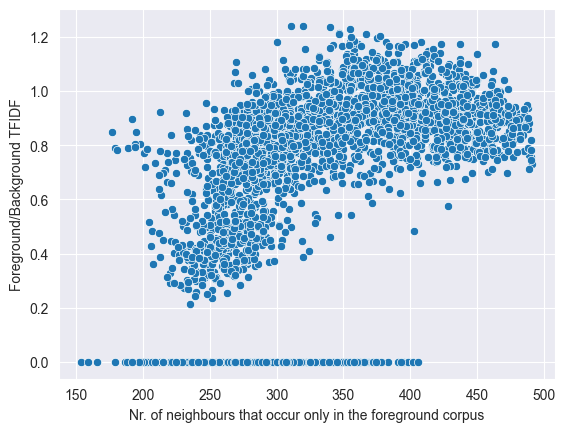

In [50]:
sns.set_style ("darkgrid")
axes = sns.scatterplot(x="num_foreground_neighbours",
                       y="TFIDF_fore_back",
                       data=span_features_df)

axes.set_xlabel("Nr. of neighbours that occur only in the foreground corpus")
axes.set_ylabel("Foreground/Background TFIDF")

This plot shows:
1. the number of foreground neighbours (the rest of the neighbours occur in the background corpus as well)
2. the TF-IDF inspired value for a span, a value of 0 indicating that the term only appears in the background corpus

Our assumption is that at certain combinations of these two values, a term is more likely to be 'domain-specific'. This allows for a crude division into domain vs out-of-domain/general domain terms. For now, we'll assume that general background domain terms have:
* a low TF-IDF value, e.g., smaller than 0.6
* at least half of the NNs being foreground terms, e.g., cut-off at 250/500

In [51]:
min_TFIDF_value = 0.6
min_num_foreground_neighbours = 250

In [52]:
# Example terms VERY TOP LEFT of the plot (expectinggeneral domain)
top = span_features_df['TFIDF_fore_back'] > 1.3 * min_TFIDF_value
left = span_features_df['num_foreground_neighbours'] < min_num_foreground_neighbours - 50
span_features_df.loc[top & left]

,span_idx,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
responsible person,355,302,198,2,0,0.803902
test procedure,512,321,179,2,0,0.787724
registration body,514,305,195,2,0,0.847372
test data,1803,311,189,2,0,0.790518
certification body,2397,306,194,2,0,0.802906
test evidence,2916,323,177,2,0,0.848365
test standards,2958,319,181,3,0,0.782034
recommendations report,2969,308,192,2,0,0.897145
management procedures,3255,306,194,2,0,0.792067


In [53]:
# Example terms very TOP RIGHT of the plot (expecting very foreground domainy)
top = span_features_df['TFIDF_fore_back'] > 1.65 * min_TFIDF_value
right = span_features_df['num_foreground_neighbours'] > 210 + min_num_foreground_neighbours
span_features_df.loc[top & right]

,span_idx,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
smoke reservoir,89,33,467,2,0,0.999581
cooker hood,184,38,462,3,0,1.073432
hallway approach,321,33,467,2,0,0.994431
Rooflight dome light,525,37,463,2,0,1.173692
liftway enclosure,1721,39,461,2,0,1.035645
rafters,1910,30,470,3,0,1.040589
flanking constructions,2299,38,462,2,0,0.992443
loading gallery,2435,35,465,2,0,1.000015
glazed screens,2443,27,473,2,0,1.006365


In [54]:
# Example terms very BOTTOM LEFT of the plot (expecting very background domainy)
bottom = span_features_df['TFIDF_fore_back'] < .1 * min_TFIDF_value
left = span_features_df['num_foreground_neighbours'] < min_num_foreground_neighbours - 65
span_features_df.loc[bottom & left]

,span_idx,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
type examination,752,321,179,0,2,0.0
clinical investigation,895,346,154,0,4,0.0
clinical investigations,1086,341,159,0,3,0.0
evaluation report,1299,334,166,0,2,0.0


In [55]:
# Example terms BOTTOM RIGHT of the plot (expecting general domain)
bottom = span_features_df['TFIDF_fore_back'] < .1 * min_TFIDF_value
right = span_features_df['num_foreground_neighbours'] > 150 + min_num_foreground_neighbours
span_features_df.loc[bottom & right]

,span_idx,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
mucous membrane,838,98,402,0,3,0.0
nasal cavity,1144,98,402,0,2,0.0
sterile pack,1241,98,402,0,2,0.0
vertical dimension,1266,94,406,0,2,0.0


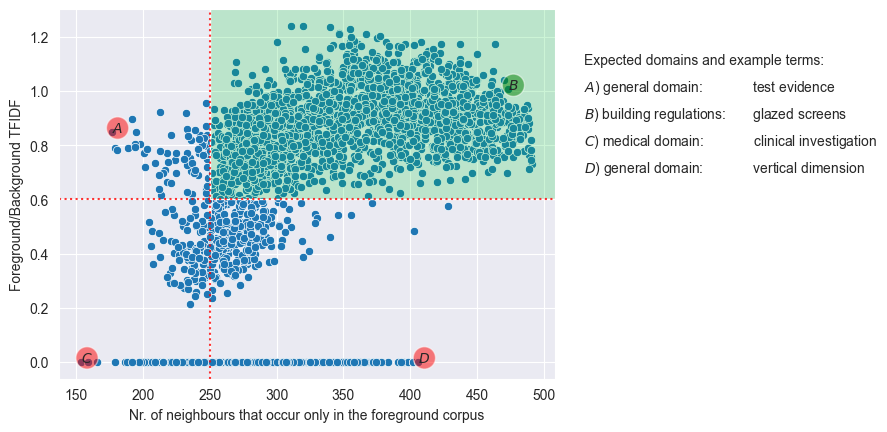

In [71]:
# We'll save the plot as a figure with example terms
fig = plt.figure()
sns.set_style ("darkgrid")
axes = sns.scatterplot(x="num_foreground_neighbours",
                       y="TFIDF_fore_back",
                       data=span_features_df)

axes.set_xlabel("Nr. of neighbours that occur only in the foreground corpus")
axes.set_ylabel("Foreground/Background TFIDF")

axes.axhline(y=min_TFIDF_value, color=(1,0,0,.8), linestyle='dotted')
axes.axvline(x=min_num_foreground_neighbours, color=(1,0,0,.8), linestyle='dotted')

topleft_term = "general domain:\t\t " + "test evidence"
topright_term = "building regulations:\t " + "glazed screens"
bottomleft_term = "medical domain:\t\t " + "clinical investigation"
bottomright_term = "general domain:\t\t " + "vertical dimension"

plt.text(530, 1.1, "Expected domains and example terms:", fontsize = 10)
for idx, term in enumerate([topleft_term, topright_term, bottomleft_term, bottomright_term]):
    x = span_features_df["num_foreground_neighbours"][term.split("\t ")[1]]
    y = span_features_df["TFIDF_fore_back"][term.split("\t ")[1]]
    colour = "green" if (x > min_num_foreground_neighbours and y > min_TFIDF_value) else "red"
    plt.text(x, y, f"${chr(97 + idx).upper()}$", fontsize = 10, bbox = dict(facecolor=colour, 
                                                                            boxstyle='circle',
                                                                            alpha = 0.5))
    plt.text(530, 1 - (.1 * idx), f"${chr(97 + idx).upper()}$) " + term, fontsize = 10)

    
# Create a Rectangle patch
rect = Rectangle((min_num_foreground_neighbours, min_TFIDF_value), 
                 520 - min_num_foreground_neighbours, 
                 1.4 - min_TFIDF_value, facecolor=(0,0.8,0.2,0.2))
# Add the patch to the Axes
axes.add_patch(rect)
fig.savefig(embedding_output_fp.joinpath("plot.jpg"), dpi=300, bbox_inches = "tight") #save as jpg

# we'll also save span_features_df for reuse elsewhere
span_features_df.to_csv(embedding_output_fp.joinpath("span_features.csv"))

* compute domain terms and exemplify

In [58]:
domain_terms = span_features_df[(span_features_df['TFIDF_fore_back'] >= min_TFIDF_value) & (span_features_df['num_foreground_neighbours'] >= min_num_foreground_neighbours)]
ood_terms = span_features_df[(span_features_df['TFIDF_fore_back'] < min_TFIDF_value) | (span_features_df['num_foreground_neighbours'] < min_num_foreground_neighbours)]


In [59]:
# we will store the domain / out-of-domain decision so we can re-use it as a dataset for a kNN voting classifier
domain_term_list = domain_terms.index.tolist()
for term in span_df_dict.keys():
    span_df_dict[term]['domain'] = 'y' if term in domain_term_list else 'n'

with open(embedding_output_fp.joinpath("span_domain_ood_dict.json"), 'w') as f:
    json.dump(span_df_dict, f)  

In [60]:

domain_unique = list(set(domain_terms.index.tolist()))
print(f"Examples of our {len(domain_unique)} AEC domain terms")
random.sample(domain_unique, 10)

Examples of our 2191 AEC domain terms


['habitable area',
 'site investigation',
 'outlet',
 'wind direction',
 'risk of blockages',
 'atmosphere',
 'sound insulation',
 'commencement',
 'wall cladding',
 'course']

In [61]:
print(f"Examples of our {len(ood_terms)} general domain terms")
random.sample(ood_terms.index.tolist(), 10)

Examples of our 1271 general domain terms


['PMCF plan',
 'means of',
 'approach',
 'relevant information',
 'revision',
 'test equipment',
 'surgical intervention',
 'comparison',
 'national provisions',
 'surveillance assessment']

* save the domain terms in the folder with inputs for our graph

In [62]:
graph_data_fp = Path("data/graph_data/")
pickle.dump(domain_unique, open(graph_data_fp.joinpath('domain_terms.pkl'), 'wb'))